<a href="https://colab.research.google.com/github/eric-pding/RSM8431-Colloquia-Assignments/blob/main/RSM8431_Module_7_CloudOps_Assignment_Phase_1_%E2%80%93_Data_Collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RSM8431 Module 7 CloudOps Assignment - Phase 1 – Data Collection

# Author: Eric Ding
# Student Number: 1007787968

# Step 0: Read the file


I used Filestar to decompressed the file and uploaded to Google Drive.

https://filestar.com/download/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Read the file
path = "/content/drive/MyDrive/Rotman Files/[Term 2] RSM8431 Colloquia/Module 7 CloudOps/lichess_db_standard_rated_2013-04.pgn"
with open(path, "r") as file:
    pgn_text = file.read()

# Step 1 : Initialize the session and define schemas

In [11]:
pip install pyspark

  Using cached pyspark-3.5.1.tar.gz (317.0 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d594ee44da766567dfbdbb49e6fc58f48bb63581a3cc767f195dfed23d04dccb
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [26]:
import re #regular expression
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType, StructType, StructField


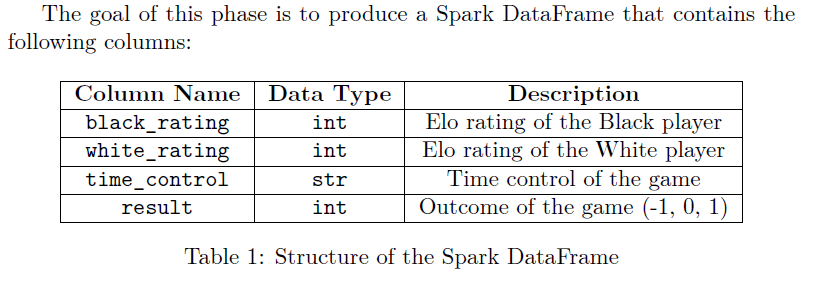

In [13]:
spark = SparkSession.builder.appName("Chess Game Analysis").getOrCreate()

schema = StructType([
    StructField("black_rating", IntegerType(), nullable=True),
    StructField("white_rating", IntegerType(), nullable=True),
    StructField("time_control", StringType(), nullable=True),
    StructField("result", IntegerType(), nullable=True)
])

# Step 2: Define function for parsing PGN headers

In [29]:
def parse_pgn_headers(pgn):
    headers = {}
    matches = re.findall(r'\[(\w+) "(.*?)"\]', pgn)
    for match in matches:
        headers[match[0]] = match[1]
    result = headers.get("Result", "unknown")
    result_code = {"1-0": 1, "0-1": -1, "1/2-1/2": 0}.get(result, 404)

    try:
        black_elo = int(headers.get("BlackElo", 0))
    except ValueError:
        black_elo = 404
    try:
        white_elo = int(headers.get("WhiteElo", 0))
    except ValueError:
        white_elo = 404

    time_control = headers.get("TimeControl", "unknown")
    return black_elo, white_elo, time_control, result_code





# Step 3: Start converting

In [30]:
parse_pgn_udf = udf(parse_pgn_headers, schema)
games = re.split(r'\n\n', pgn_text)
rows = [parse_pgn_headers(games[i]) for i in range(len(games)) if parse_pgn_headers(games[i]) != (0, 0, "unknown", 404)]




+------------+------------+------------+------+
|black_rating|white_rating|time_control|result|
+------------+------------+------------+------+
|        2259|        1875|         0+1|     1|
|        1472|        1673|       180+0|     1|
|        1578|        1386|     1740+30|     1|
|        1900|        2232|         0+1|     1|
|        1664|        1726|       480+1|     1|
+------------+------------+------------+------+
only showing top 5 rows



# Step 4: write to parquet

In [32]:
chess = spark.createDataFrame(rows, schema)

chess.show(20)

+------------+------------+------------+------+
|black_rating|white_rating|time_control|result|
+------------+------------+------------+------+
|        2259|        1875|         0+1|     1|
|        1472|        1673|       180+0|     1|
|        1578|        1386|     1740+30|     1|
|        1900|        2232|         0+1|     1|
|        1664|        1726|       480+1|     1|
|        1419|        1586|       300+3|     1|
|        1347|        1319|       300+8|     1|
|        1878|        2256|         0+1|     1|
|        1890|        1626|       120+0|     1|
|        1697|        1819|       300+8|     1|
|        1917|        1833|       300+0|     1|
|        1429|        1457|       300+8|    -1|
|        1397|        1536|       300+0|     1|
|        1460|        1616|        60+1|     1|
|        1500|        1370|       300+1|    -1|
|        1465|        1563|        60+4|     1|
|        1319|        1637|      600+10|     1|
|        1695|        1741|       180+2|

In [34]:
output = "/content/drive/MyDrive/Rotman Files/[Term 2] RSM8431 Colloquia/Module 7 CloudOps/lichess_db_standard_rated_2013-04.parquet"

chess.write.parquet(output)


Parquet files are saved at: /content/drive/MyDrive/Rotman Files/[Term 2] RSM8431 Colloquia/Module 7 CloudOps/lichess_db_standard_rated_2013-04.parquet
